# Week 3: Classical ML Algorithms

**Topics:** Regression, Classification, Model Evaluation

---

## Environment Setup

Before running this notebook, you need **Python 3.10+** and a few libraries.

**1. Install Python** (if you don't have it): [python.org/downloads](https://www.python.org/downloads/)

**2. Install an IDE:** [Cursor](https://www.cursor.com/) or [VS Code](https://code.visualstudio.com/)

**3. Set up a virtual environment** (run these in your terminal):
```bash
# Create a virtual environment
python3 -m venv venv

# Activate it
# macOS/Linux:
source venv/bin/activate
# Windows:
venv\Scripts\activate

# Install dependencies
pip install -r requirements.txt
```

**4. Select the kernel** — in your IDE, make sure the notebook is using the `venv` Python interpreter, not your system Python.

---

Last week you learned how to wrangle data with pandas and numpy. Today we'll use that data to actually **make predictions**.

## What is Supervised Learning?

**Supervised learning** = you have some data, and you want to predict something you don't know.

- **Features** — the information you already have (the inputs)
- **Labels/Targets** — the thing you're trying to predict

| Type | What you're predicting | Example |
|------|------------------------|---------|
| **Regression** | A number | Hours studied → **exam score** |
| **Classification** | A category | Email text → **spam or not spam** |

In [ ]:
# Setup — run this cell first
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Make plots look nicer
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (8, 5)

---
## Part 1: Regression

**Goal:** Given some input data, predict a number.

Example: if you know how many hours a student studied, can you predict their exam score?

### 1.1 Generate Data

We'll create fake "hours studied vs exam score" data so we can focus on the ML, not data cleaning.

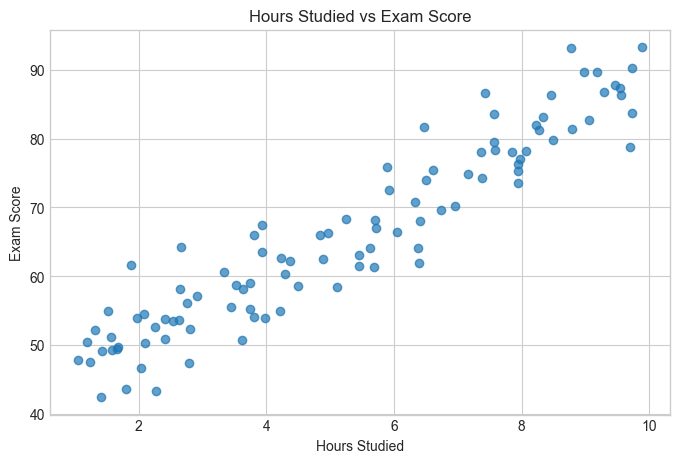

In [16]:
np.random.seed(42)

# Generate fake data: 100 students
hours_studied = np.random.uniform(1, 10, 100)                   # 1 to 10 hours
exam_score = 40 + 5 * hours_studied + np.random.normal(0, 5, 100)  # rough trend + noise

X = hours_studied.reshape(-1, 1)  # sklearn expects 2D input
y = exam_score

plt.scatter(X, y, alpha=0.7)
plt.xlabel('Hours Studied')
plt.ylabel('Exam Score')
plt.title('Hours Studied vs Exam Score')
plt.show()

### 1.2 Train/Test Split

Split the data so the model is evaluated on examples it **hasn't seen before**.

- **Training set** — model learns from this
- **Test set** — held out to check real performance

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Training samples: {len(X_train)}')
print(f'Test samples:     {len(X_test)}')

Training samples: 80
Test samples:     20


### 1.3 Fit a Linear Regression Model

The sklearn pattern (works for **every** model):

1. `model = Model()` — **Create**
2. `model.fit(X_train, y_train)` — **Fit**
3. `model.predict(X_test)` — **Predict**

In [20]:
from sklearn.linear_model import LinearRegression

# 1. Create
model = LinearRegression()

# 2. Fit (80)
model.fit(X_train, y_train)

# 3. Predict (20)
y_pred = model.predict(X_test)

# Let's look at a few predictions vs actual values
comparison = pd.DataFrame({'Actual': y_test[:5], 'Predicted': y_pred[:5]})
print(comparison.to_string(index=False))

   Actual  Predicted
51.142894  48.447146
82.749852  84.186091
73.566261  78.915869
70.266566  74.198544
60.600259  56.840356


### 1.4 Visualize the Fit

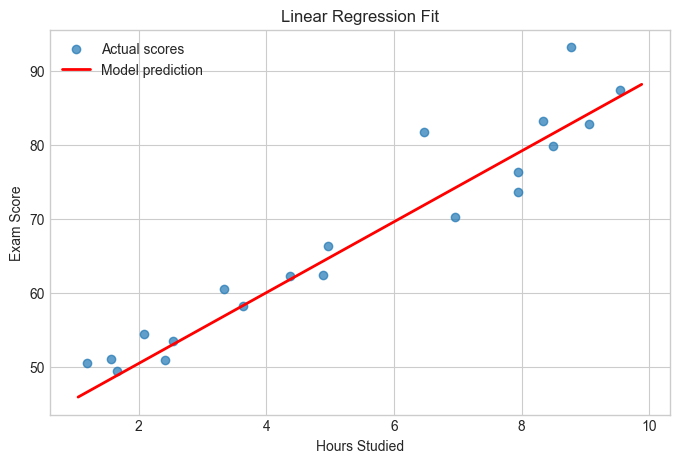

In [21]:
plt.scatter(X_test, y_test, alpha=0.7, label='Actual scores')

# Draw the regression line
X_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
plt.plot(X_line, model.predict(X_line), color='red', linewidth=2, label='Model prediction')

plt.xlabel('Hours Studied')
plt.ylabel('Exam Score')
plt.title('Linear Regression Fit')
plt.legend()
plt.show()

### 1.5 Regression Metrics

| Metric | What it means | Good value |
|--------|---------------|------------|
| **MSE** | Average squared error. Lower = better. | Depends on data scale |
| **R² Score** | Fraction of variance explained. | 1.0 = perfect, 0.0 = useless |

In [22]:
from sklearn.metrics import mean_squared_error, r2_score

r2 = r2_score(y_test, y_pred)

print(f'R² Score:           {r2:.4f}')

R² Score:           0.9120


---
## Part 2: Classification

**Goal:** Predict which category something belongs to.

We'll use the classic **Iris dataset** — 150 flowers, 4 measurements each, 3 species.

### 2.1 Load and Explore the Data

**Iris dataset:** 150 flowers, 4 measurements, 3 species.

In [25]:
from sklearn.datasets import load_iris

iris = load_iris()

# Put it in a DataFrame so it's easier to look at
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = iris.target  # 0, 1, or 2

print('Classes:', iris.target_names)
print(f'Samples: {len(df)}')
print()
df.head()

Classes: ['setosa' 'versicolor' 'virginica']
Samples: 150



,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


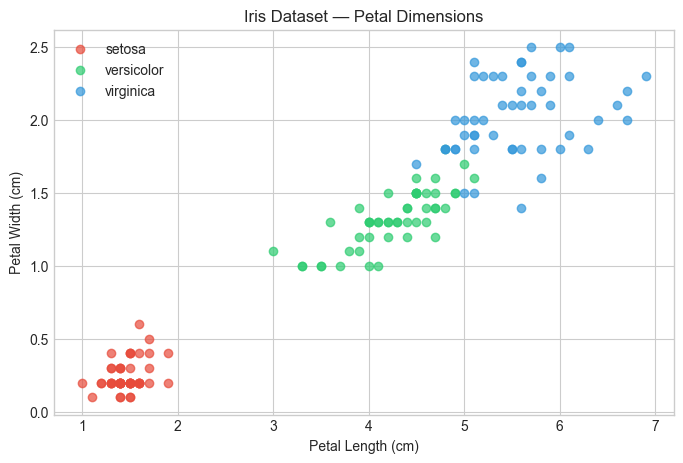

In [26]:
# Quick visualization: plot 2 features, color by species
colors = ['#e74c3c', '#2ecc71', '#3498db']
for i, name in enumerate(iris.target_names):
    mask = df['species'] == i
    plt.scatter(df.loc[mask, 'petal length (cm)'],
                df.loc[mask, 'petal width (cm)'],
                label=name, color=colors[i], alpha=0.7)

plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.title('Iris Dataset — Petal Dimensions')
plt.legend()
plt.show()

The species form visible **clusters** — a classifier should be able to learn these boundaries.

### 2.2 K-Nearest Neighbors (KNN)

**How it works:** To classify a new point, find the K closest training points and take a majority vote.

Same pattern: **Create → Fit → Predict**

In [29]:
from sklearn.neighbors import KNeighborsClassifier

X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Create (K=5 neighbors)
knn = KNeighborsClassifier(n_neighbors=5)

# 2. Fit
knn.fit(X_train, y_train)

# 3. Predict
y_pred = knn.predict(X_test)

# Compare a few predictions
comparison = pd.DataFrame({
    'Actual': [iris.target_names[i] for i in y_test[:8]],
    'Predicted': [iris.target_names[i] for i in y_pred[:8]]
})
print(comparison.to_string(index=False))

    Actual  Predicted
versicolor versicolor
    setosa     setosa
 virginica  virginica
versicolor versicolor
versicolor versicolor
    setosa     setosa
versicolor versicolor
 virginica  virginica


### 2.3 Evaluate: Accuracy

Simplest metric: **what fraction of predictions were correct?**

In [30]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.2%}')

Accuracy: 100.00%


---
## Part 3: Model Evaluation Deep Dive

### 3.1 Overfitting vs Underfitting

| | Too complex | Too simple |
|---|---|---|
| **Name** | Overfitting | Underfitting |
| **KNN example** | K = 1 (memorizes) | K = 50 (too blunt) |
| **Training accuracy** | Very high | Low |
| **Test accuracy** | Drops | Also low |

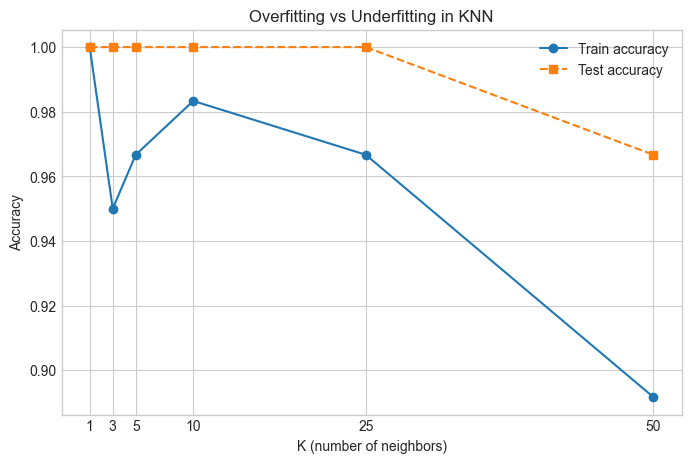

In [36]:
k_values = [1, 3, 5, 10, 25, 50]
train_scores = []
test_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))

plt.plot(k_values, train_scores, 'o-', label='Train accuracy')
plt.plot(k_values, test_scores, 's--', label='Test accuracy')
plt.xlabel('K (number of neighbors)')
plt.ylabel('Accuracy')
plt.title('Overfitting vs Underfitting in KNN')
plt.legend()
plt.xticks(k_values)
plt.show()

**Key insight:** At K=1, training accuracy is perfect but test accuracy drops (overfitting). At large K, both drop (underfitting). The sweet spot is in the middle.

---
## Recap

| Concept | Key Takeaway |
|---------|-------------|
| **Regression** | Predict a number from input data (e.g. hours studied → exam score). Evaluate with R². |
| **Classification** | Predict a category from input data (e.g. measurements → flower species). Evaluate with accuracy, confusion matrix. |
| **Train/Test Split** | Always hold out data the model hasn't seen to evaluate fairly. |
| **Confusion Matrix** | Shows exactly *where* the model makes mistakes. |
| **Overfitting** | Model is too complex — great on training data, bad on test data. |
| **Underfitting** | Model is too simple — bad on everything. |

**The sklearn pattern:** `model = Model()` → `model.fit(X_train, y_train)` → `model.predict(X_test)`

**Next week:** Feature engineering, regularization, and cross-validation.

---
## Bonus: Try It Yourself

If you finish early, try these:

1. **Swap the classifier:** Replace `KNeighborsClassifier` with `DecisionTreeClassifier` from `sklearn.tree`. Does accuracy change?
2. **Noisier regression:** Re-run the regression section with `noise=50` instead of `noise=15`. What happens to R²?
3. **Feature importance:** Which iris features matter most? Try training KNN with only 2 features at a time and compare accuracy.